<div class="alert alert-info">

<H1> Data Analysis Challenge: Relax Inc.</H1>
Relax Inc. makes productivity and project management software that's popular with both individuals and teams. It is considered a great company to work for.
</div>

<div class="alert alert-info">

<H2> Context </H2>

The data is available as two CSV files:

+ `takehome_user_engagement.csv`
+ `takehome_users.csv`
    
The data has the following two tables:
    
+ A user table (`takehome_users`) with data on 12,000 users who signed up for the product in the last two years. This table includes:
    
    + `name`: the user's name
    + `object_id`: the user's id
    + `email`: email address
    + `creation_source`: how their account was created. This takes on one of 5 values:
        + `PERSONAL_PROJECTS`: invited to join another user's personal workspace
        + `GUEST_INVITE`: invited to an organization as a guest (limited permissions)
        + `ORG_INVITE`: invited to an organization (as a full member)
        + `SIGNUP`: signed up via the website
        + `SIGNUP_GOOGLE_AUTH`: signed up using Google Authentication (using a Google email account for their login id)
    + `creation_time`: when they created their account
    + `last_session_creation_time`: unix timestamp of last login
    + `opted_in_to_mailing_list`: whether they have opted into receiving
marketing emails
    + `enabled_for_marketing_drip`: whether they are on the regular
marketing email drip
    + `org_id`: the organization (group of users) they belong to
    + `invited_by_user_id`: which user invited them to join (if applicable).
    
    
+ A usage summary table (`takehome_user_engagement`) that has a row for each day that a user logged into the product.
    

<h3> Objective </h3>
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, <b>identify which factors predict future user adoption</b>.
</div>

# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Load and Explore Data

In [2]:
# Load data 
df_user = pd.read_csv("takehome_users.csv", encoding="ISO-8859-1")
print(f"\ndf_user.shape: {df_user.shape}\n")
print(f"\ndf_user.isnull().sum():\n\n{df_user.isnull().sum()}\n")


df_user.shape: (12000, 10)


df_user.isnull().sum():

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64



In [3]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_eng = pd.read_csv("takehome_user_engagement.csv", parse_dates=["time_stamp"])
print(f"\ndf_eng.shape: {df_eng.shape}\n")
print(f"\ndf_eng.isnull().sum():\n\n{df_eng.isnull().sum()}\n")


df_eng.shape: (207917, 3)


df_eng.isnull().sum():

time_stamp    0
user_id       0
visited       0
dtype: int64



In [5]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
df_user = df_user.rename({"object_id":"user_id"}, axis=1)
df_user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Data Wrangling

In [7]:
# Determine 'adopted user'
df_agg = df_eng.set_index("time_stamp")

users = df_agg["user_id"].unique()
adoption = []

for i in users:
    id_filter = df_agg["user_id"] == i
    df_filter = df_agg[id_filter].resample("1D").count()
    df_filter = df_filter.rolling(window=7).sum()
    df_filter = df_filter.dropna()
    adoption.append(any(df_filter["visited"].values >= 3))

In [8]:
df_agg.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [9]:
np.sum(adoption)

1597

In [10]:
# Create a dataframe with "user_id" and "adopted_user"
user_adoption = list(zip(users, adoption))

df_adopt = pd.DataFrame(user_adoption)
df_adopt.columns = ["user_id", "adopted_user"]

df = df_user.merge(df_adopt, on="user_id", how="left")

In [11]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [12]:
print(f"\ndf.shape: {df.shape}\n")
print(f"\ndf.isnull().sum():\n\n{df.isnull().sum()}\n")


df.shape: (12000, 11)


df.isnull().sum():

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  3177
dtype: int64



In [13]:
df.adopted_user.sum()

1597

There are 3177 missing values for `last_session_creation_time`. This means all these users never logged on and they are not `adopted_user`. The number of missing values of `adopted_user` is also same as 3177. We will assign `False` or `0` values to `adopted_user` feature for all these users.

In [14]:
# Mapping 'adopted_user'
df.loc[:, "adopted_user"] = df["adopted_user"].map({False:0, True:1, np.nan:0})
df.dropna(subset=["adopted_user"], inplace=True)
df["adopted_user"] = df["adopted_user"].astype(int)

In [15]:
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [16]:
# Handling 'invited_by_user' missing values
# We will drop the 'invited_by_user_id' column before modeling
invite = lambda row: 0 if np.isnan(row) else 1
df["invited_by_user"] = df["invited_by_user_id"].apply(invite)

In [17]:
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
invited_by_user                  0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
 11  invited_by_user             12000 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 1.2+ MB


In [19]:
# Create a feature of user history
# Convert both time features into datetime
df['creation_time'] = pd.to_datetime(
    df['creation_time'], format='%Y-%m-%d %H:%M:%S')
df['last_session_creation_time'] = pd.to_datetime(
    df['last_session_creation_time'], unit='s')

# Calculate user history, defined as number of days between account creation
# and last use
df['history'] = df['last_session_creation_time'] - df['creation_time']
df['history'] = df['history'].dt.days

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                12000 non-null  int64         
 11  invited_by_user             12000 non-null  int64     

In [21]:
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
invited_by_user                  0
history                       3177
dtype: int64

In [22]:
# Collect all the featuers that I think are relevant 
df = df[["adopted_user", "history", "invited_by_user", "creation_source", \
         "opted_in_to_mailing_list", "enabled_for_marketing_drip"]]

In [23]:
df.head()

,adopted_user,history,invited_by_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip
0,0,0.0,1,GUEST_INVITE,1,0
1,1,136.0,1,ORG_INVITE,0,0
2,0,0.0,1,ORG_INVITE,0,0
3,0,1.0,1,GUEST_INVITE,0,0
4,0,5.0,1,GUEST_INVITE,0,0


In [24]:
df.shape

(12000, 6)

In [25]:
df.isnull().sum()

adopted_user                     0
history                       3177
invited_by_user                  0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
dtype: int64

Now delete all the rows that has missing values in `history`.

In [26]:
df.dropna(inplace = True)

In [27]:
df.shape

(8823, 6)

In [28]:
df.isnull().sum()

adopted_user                  0
history                       0
invited_by_user               0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
dtype: int64

In [29]:
print(f"There were {df.adopted_user.sum()} adopted users out of {df.shape[0]} users.")

There were 1597 adopted users out of 8823 users.


**This is an imbalance data set.**

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopted_user                8823 non-null   int64  
 1   history                     8823 non-null   float64
 2   invited_by_user             8823 non-null   int64  
 3   creation_source             8823 non-null   object 
 4   opted_in_to_mailing_list    8823 non-null   int64  
 5   enabled_for_marketing_drip  8823 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 482.5+ KB


In [31]:
df.head()

,adopted_user,history,invited_by_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip
0,0,0.0,1,GUEST_INVITE,1,0
1,1,136.0,1,ORG_INVITE,0,0
2,0,0.0,1,ORG_INVITE,0,0
3,0,1.0,1,GUEST_INVITE,0,0
4,0,5.0,1,GUEST_INVITE,0,0


# Exploratory Data Analysis

In [32]:
# Feature history and adopted user
def plot_hist_days(df, col, xlabel):
    
    plt.figure(dpi = 100)
    _ = plt.hist(df.loc[df['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[df['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])

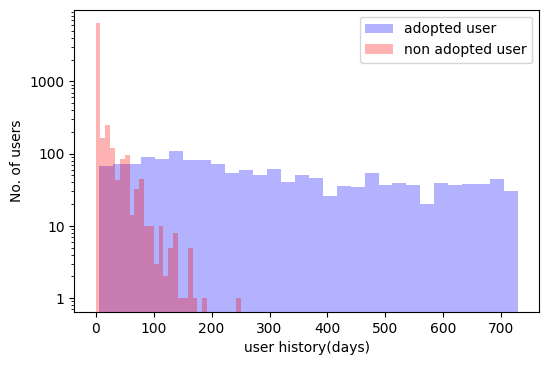

In [33]:
# Plot
plot_hist_days(df, 'history', 'user history(days)')

We see that users with long history are more likely to be adopted users.

# Data Preprocessing and Modeling

In [34]:
# Make dummy variable for creation source
df = pd.get_dummies(df, columns = ['creation_source'])

In [35]:
df.head()

,adopted_user,history,invited_by_user,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,0,0.0,1,1,0,1,0,0,0,0
1,1,136.0,1,0,0,0,1,0,0,0
2,0,0.0,1,0,0,0,1,0,0,0
3,0,1.0,1,0,0,1,0,0,0,0
4,0,5.0,1,0,0,1,0,0,0,0


In [36]:
df.shape

(8823, 10)

In [37]:
# Define features and target
X = df[df.columns[1:]]
y = df[df.columns[0]]

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Estimator
# Pass class_weight='balanced' because of imbalance data set
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# GridSearchCV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
rf_grid_cv = GridSearchCV(clf, params)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 200]})

In [38]:
# Print best parameters and results

print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_score_)

{'n_estimators': 10}
0.9530462639047208


In [39]:
# Train score
y_train_pred = rf_grid_cv.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train set accuracy: {train_accuracy}")

Train set accuracy: 0.9781411917098446


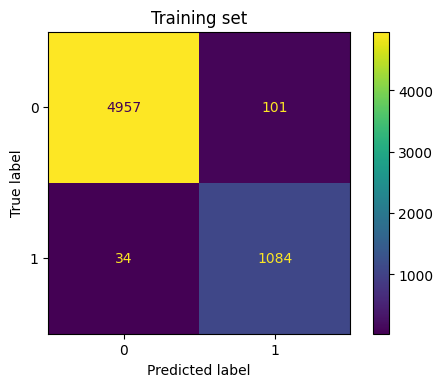

In [40]:
plt.figure(dpi = 100)
ax = plt.subplot(111)
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
plt.title(f"Training set")
plt.show()

In [41]:
# Test score
y_test_pred = rf_grid_cv.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.9501322251605592


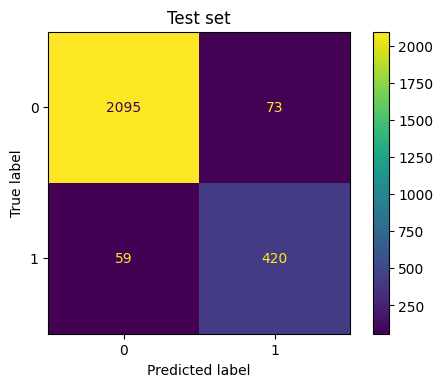

In [42]:
plt.figure(dpi = 100)
ax = plt.subplot(111)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
plt.title(f"Test set")
plt.show()

**The model performance is very good**.

Refer to this [stackoverflow response](https://stackoverflow.com/questions/48377296/get-feature-importance-from-gridsearchcv#:~:text=If%20you%20are%20using%20a%20pipeline) about how to extract the `feature_importances_`

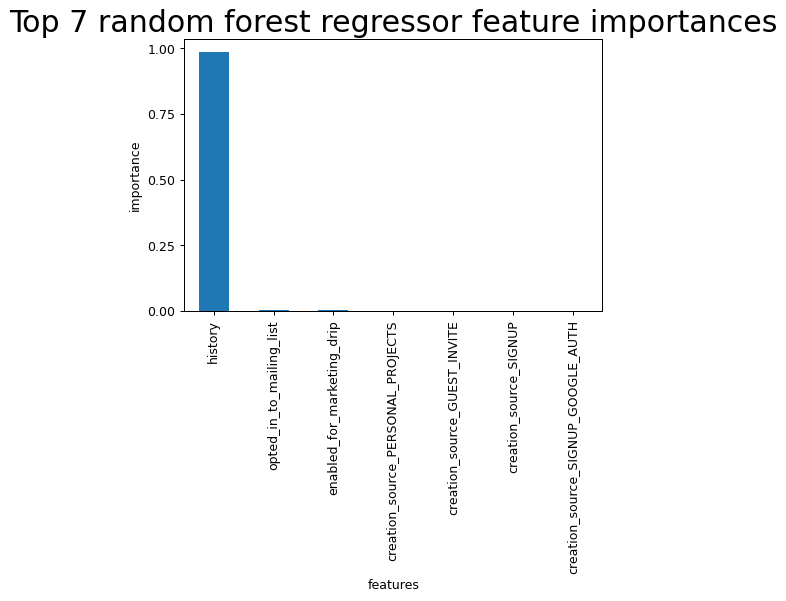

In [43]:
# Feature importance
plt.subplots(dpi=90)
imps = rf_grid_cv.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps[0:7].plot(kind='bar')
plt.rc('font', size=20)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Top 7 random forest regressor feature importances');

We can also print them.

In [44]:
# Print feature importance
imp = pd.Series(rf_grid_cv.best_estimator_.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                               0.985502
opted_in_to_mailing_list              0.003657
enabled_for_marketing_drip            0.002600
creation_source_PERSONAL_PROJECTS     0.002130
creation_source_GUEST_INVITE          0.002088
creation_source_SIGNUP                0.001532
creation_source_SIGNUP_GOOGLE_AUTH    0.001121
creation_source_ORG_INVITE            0.000725
invited_by_user                       0.000645
dtype: float64


# Conclusions

The performance of our model is pretty good. The user history (`history`), a feature that we derived from other existing features, is the most important feature with a feature importance score of `0.99`. The rest of the features are hardly relevant. So, it is recommended to sketch out a plan that will encourage the existing users to log in and use the software once they create an account.